# Previsão de Idade e Gênero

A análise de imagens faciais para a prever idade e gênero tornou-se uma aplicação significativa da visão computacional e aprendizado de máquina. Esse projeto tem como objetivo desenvolver um preditor de idade e gênero utilizando Redes Neurais Convolucionais (CNNs), extraindo características das imagens faciais para estimando idade e gênero associados ao rosto.

## Imports

In [2]:
# manipulacao de dados
import pandas as pd
import numpy as np
import os
import random

# graficos
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# tratamento de imagens
from PIL import Image

# aprendizado de maquina
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.utils import plot_model

## Coletando amostras

In [4]:
# diretório com as imagens
base_dir = 'base/utkface_aligned_cropped/UTKFace'

In [5]:
# coleta imagens da pasta
image_paths = []
ages = []
genders = []
gender_dict = {0:'Male', 1:'Female'}

# caso queira limitar o número de amostras (23708 disponíveis)
interval = 15000

for img_file in os.listdir(base_dir)[0:interval]:
    img_path = os.path.join(base_dir, img_file)
    aux = img_file.split('_') # quebra o nome do arquivo para extrair idade e genero
    age = int(aux[0])
    gender = int(aux[1])

    image_paths.append(img_path)
    ages.append(age)
    genders.append(gender)

In [6]:
# transformando em dataframe
df = pd.DataFrame()

df['image'], df['age'], df['gender'] = image_paths, ages, genders
df = df[df['gender'] != 3]
df

,image,age,gender
0,base/utkface_aligned_cropped/UTKFace/42_0_0_20...,42,0
1,base/utkface_aligned_cropped/UTKFace/36_0_3_20...,36,0
2,base/utkface_aligned_cropped/UTKFace/26_0_3_20...,26,0
3,base/utkface_aligned_cropped/UTKFace/52_1_1_20...,52,1
4,base/utkface_aligned_cropped/UTKFace/3_0_0_201...,3,0
...,...,...,...
14995,base/utkface_aligned_cropped/UTKFace/35_0_0_20...,35,0
14996,base/utkface_aligned_cropped/UTKFace/34_0_0_20...,34,0
14997,base/utkface_aligned_cropped/UTKFace/30_0_1_20...,30,0
14998,base/utkface_aligned_cropped/UTKFace/37_0_3_20...,37,0


## Analisando amostras

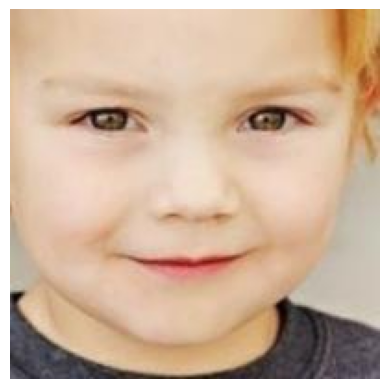

In [14]:
rand_index = random.randint(0, len(df)-1)
example_img = Image.open(df['image'][rand_index])
plt.axis('off')
plt.imshow(example_img)

<Axes: xlabel='age', ylabel='Density'>

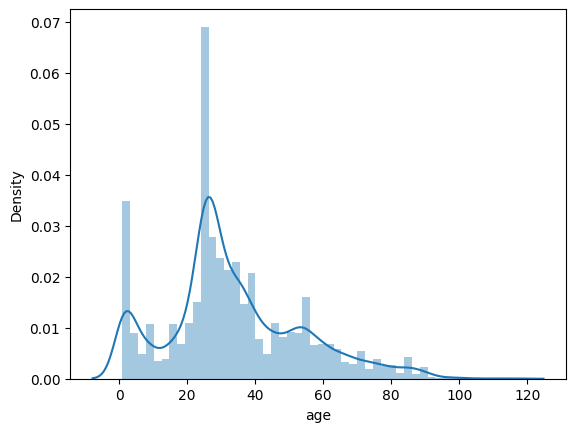

In [15]:
# distribuição de idades
sns.distplot(df['age'])

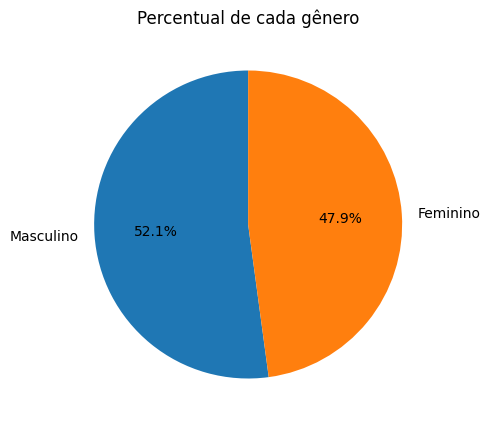

In [9]:
# conta a quantidade de cada gênero
gender_counts = df['gender'].value_counts()

# grafico de pizza pra quantidade de cada gênero
plt.figure(figsize=(15, 5))
# plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.pie(gender_counts, labels=["Masculino", "Feminino"], autopct='%1.1f%%', startangle=90)
plt.title('Percentual de cada gênero')
plt.show()


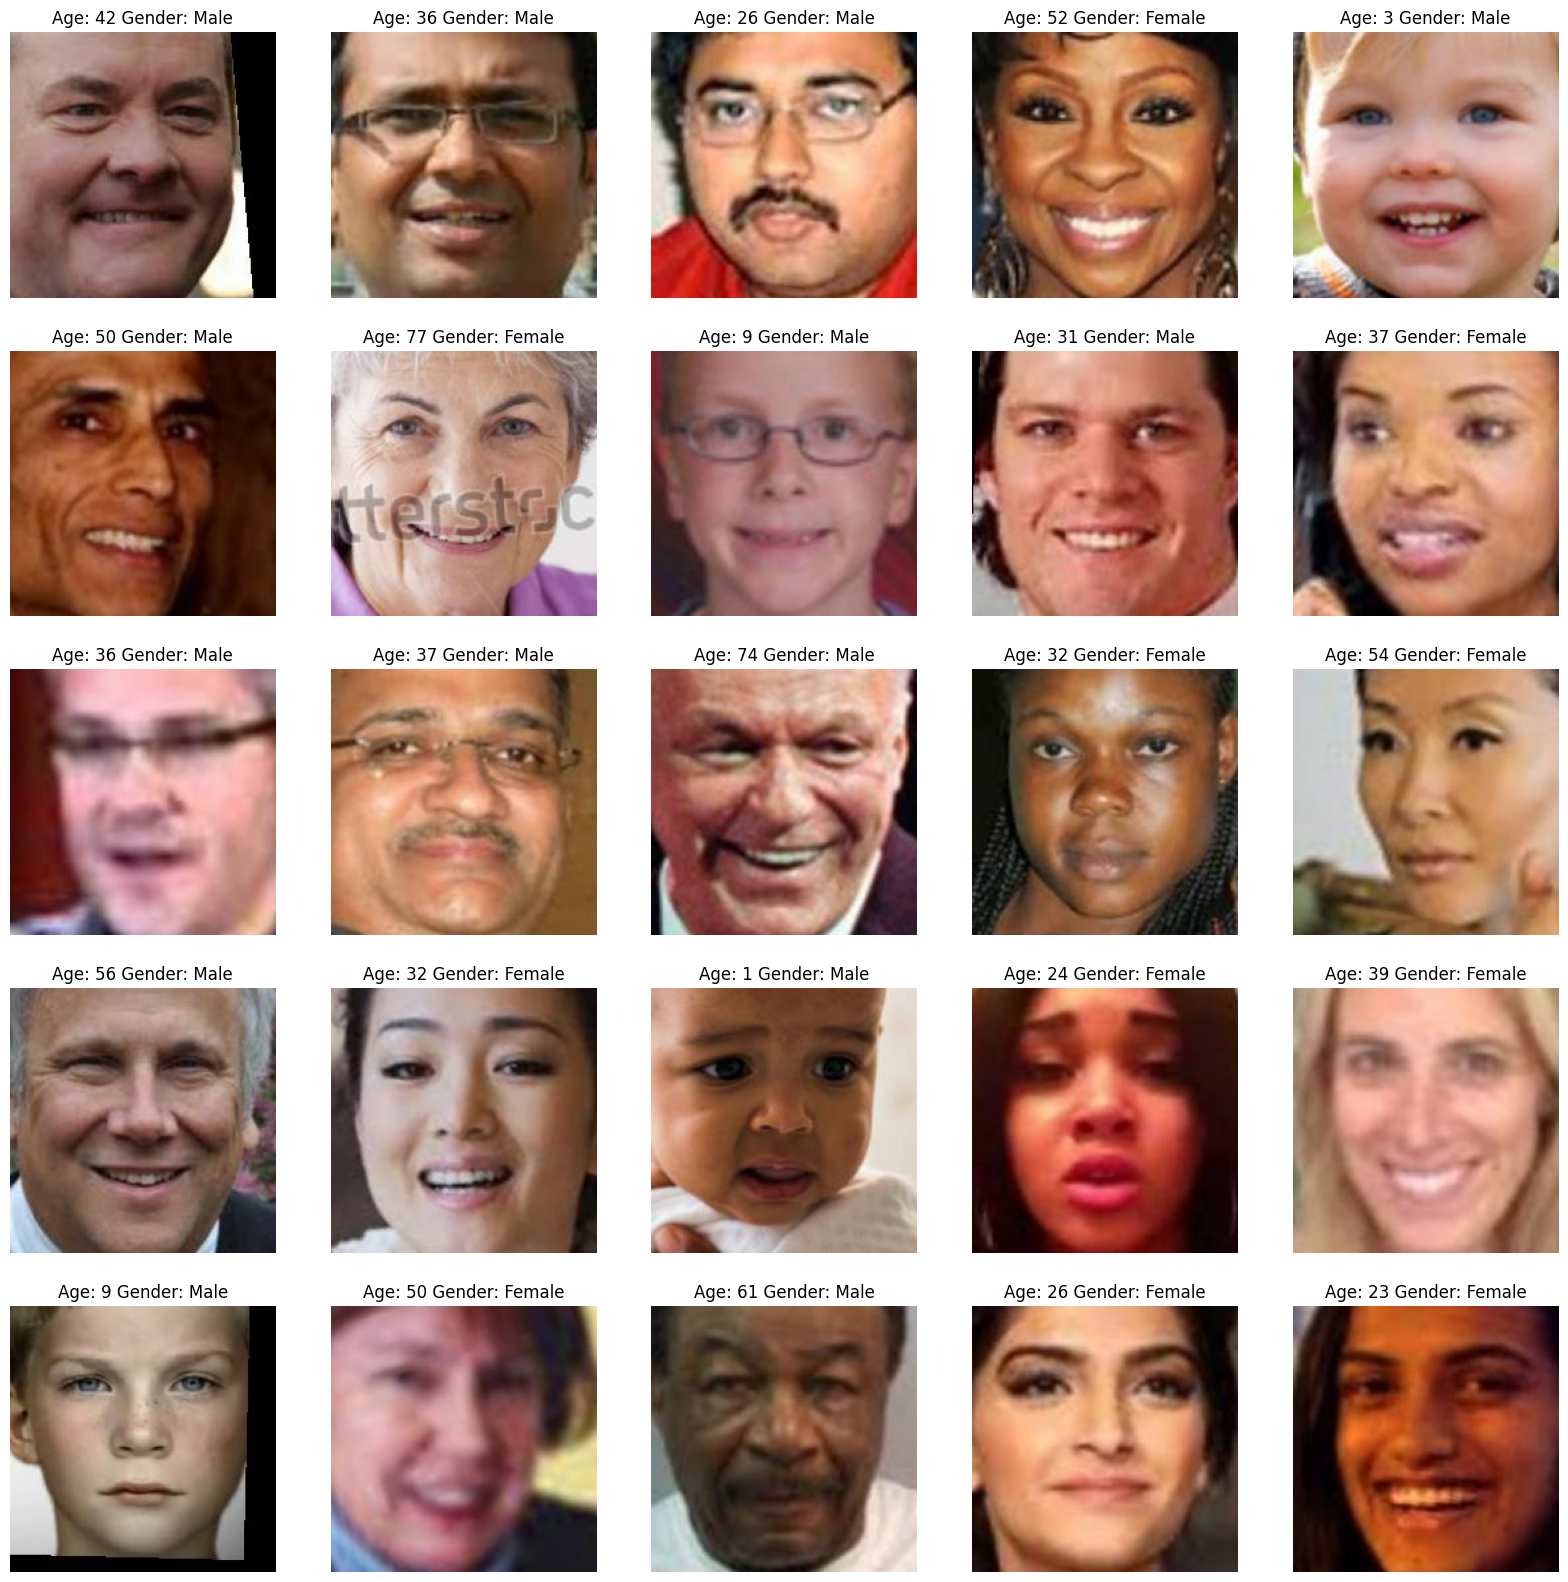

In [10]:
# alguns exemplos de amostras
# mostra 25 amostras aleatórias, com sua respectiva idade e gênero

plt.figure(figsize=(20, 20))
imgs = df.iloc[0:25]

for index, file, age, gender in imgs.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Extraíndo características (e tentando otimizar as fotos)
Vamos definir uma função para extrair as features das imagens, e também redimensionar as imagens (atualmente com 200x200 pixels) para 128x128 pixels e armazená-las em preto e branco para economizar espaço.

In [11]:
def extract_features(images):
    features = []
    for image in images:
        # transforma em escala de cinza
        # basta ignorar se quiser imagens coloridas
        img = load_img(image, grayscale=True) 
        img = img.resize((128, 128)) # redimensiona
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # basta ignorar se usar imagens coloridas
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
# testando nossa função
X = extract_features(df['image'])
X.shape

(15000, 128, 128, 1)

In [13]:
# queremos que todos os pixels estejam entre 0 e 1, então vamos dividir por 255
X = X / 255.0 # normalizando os pixels de todas as imagens

## O modelo

In [14]:
# convertendo genero e idade para array
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

# determinando o shape das imagens - conforme vimos anteriormente em X.shape
input_shape = (128, 128, 1)

### Criação

O modelo é criado para prever a idade e o gênero da pessoa, sendo o primeiro um valor numérico (maior que 0) e o segundo, binário (0 para masculino, 1 para feminino). Para isso, usamos uma rede neural convolucional (CNN) com 3 camadas convolucionais, 3 camadas de pooling e 3 camadas densas. A função de ativação utilizada é a ReLU, a função de perda é a MSE (Mean Squared Error) e as funções de saída são ReLU (numérico, para idades) e Sigmoid (binário, para gêneros).

In [16]:
inputs = Input((input_shape))

# camadas convolucionais
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs) # usa 32 filtros de 3x3
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1) # reduz a dimensionalidade da imagem

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4) # transforma a matriz em um vetor

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

# evita overfitting
dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

# camadas densas de output
output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1) # sigmoid -> classificação binária
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2) # relu -> predição numérica	

model = Model(inputs=[inputs], outputs=[output_1, output_2])

# compila usando funcoes de perda -> binary_crossentropy para o gênero e mae para a idade
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy']) # métrica monitorada -> acurácia

# plot_model(model)

### Treino

In [17]:
# treinando o modelo com 20% dos dados para teste
# a qntd de epochs e o tamanho do batche são especificados de acordo com o hardware disponivel
epochs = 30
batch_size = 32

history = model.fit(x=X, y=[y_gender, y_age], batch_size=batch_size, epochs=epochs, validation_split=0.2)
# quanto maior o batch_size, mais memoria é necessaria
# quanto mais epochs, maior a acurácia do modelo

Epoch 1/30
375/375 [==============================] - 85s 221ms/step - loss: 16.5422 - gender_out_loss: 0.7063 - age_out_loss: 15.8359 - gender_out_accuracy: 0.5153 - age_out_accuracy: 0.0480 - val_loss: 15.6490 - val_gender_out_loss: 0.6905 - val_age_out_loss: 14.9585 - val_gender_out_accuracy: 0.5627 - val_age_out_accuracy: 0.0457
Epoch 2/30
375/375 [==============================] - 79s 210ms/step - loss: 14.3020 - gender_out_loss: 0.6042 - age_out_loss: 13.6978 - gender_out_accuracy: 0.6684 - age_out_accuracy: 0.0476 - val_loss: 12.1012 - val_gender_out_loss: 0.4988 - val_age_out_loss: 11.6024 - val_gender_out_accuracy: 0.7610 - val_age_out_accuracy: 0.0437
Epoch 3/30
375/375 [==============================] - 86s 230ms/step - loss: 11.7498 - gender_out_loss: 0.4978 - age_out_loss: 11.2520 - gender_out_accuracy: 0.7642 - age_out_accuracy: 0.0317 - val_loss: 11.2553 - val_gender_out_loss: 0.4734 - val_age_out_loss: 10.7819 - val_gender_out_accuracy: 0.7630 - val_age_out_accuracy: 0.

## Resultados obtidos

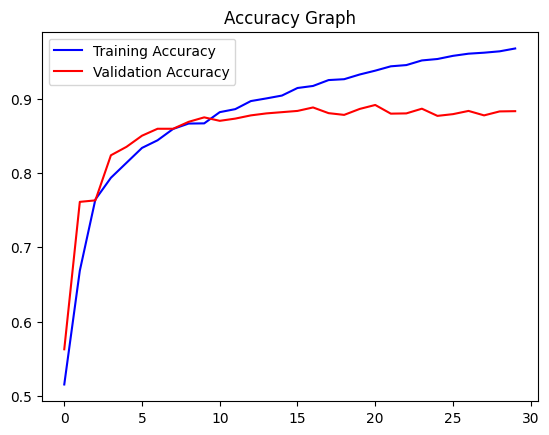

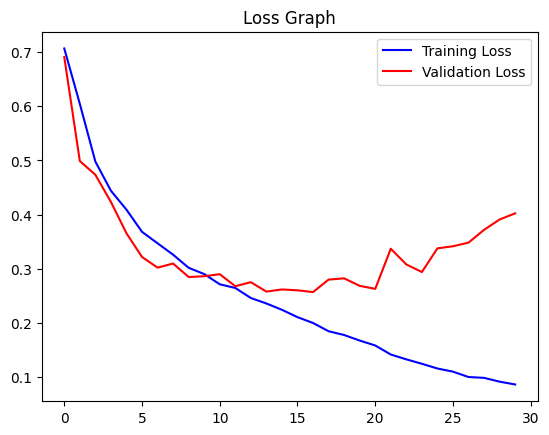

In [18]:
# plot resultados de genero
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

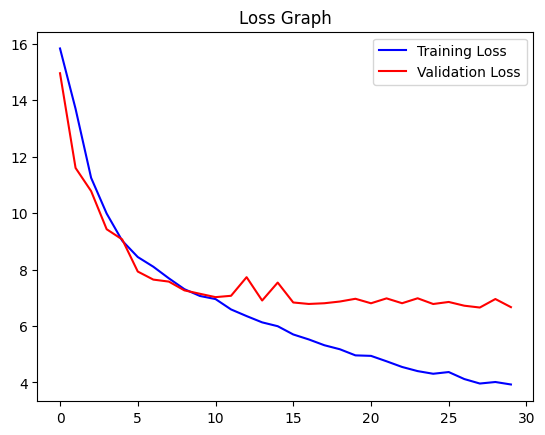

In [19]:
# plot resultados de idade
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Aplicação
Finalmente, podemos testar o modelo!!!

Original Gender: Female Original Age: 7
1/1 [==============================] - 0s 47ms/step
Predicted Gender: Female Predicted Age: 4


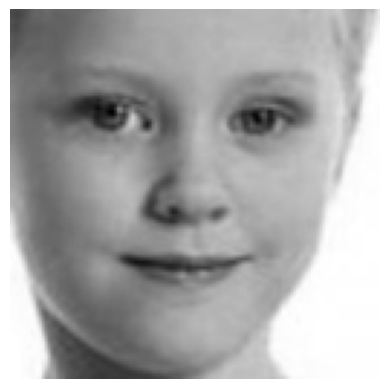

In [26]:

image_index = 499
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# predição a partir do modelo
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

## Salvando o modelo treinado
Podemos usar funções do módulo `Keras` para salvar o modelo treinado e carregá-lo posteriormente. Usaremos a `save_model('nome_do_arquivo')` para salvar o modelo como um arquivo `.h5` e `load_model('nome_do_arquivo')` para carregá-lo posteriormente em outros notebooks (`savedModel` e `getImage`).

In [22]:
save_num = 1
model_file = 'modelo' + str(save_num) + '.h5'
# salvando o modelo
model.save(model_file)

# para carregar modelo
# loaded_model = load_model('modelo.h5')
